## Basemap Examples

https://matplotlib.org/basemap/users/examples.html

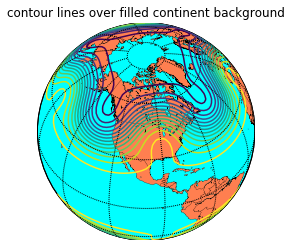

In [5]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
map = Basemap(projection='ortho',lat_0=45,lon_0=-100,resolution='l')
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='coral',lake_color='aqua')
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))
# make up some data on a regular lat/lon grid.
nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)
lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])
wave = 0.75*(np.sin(2.*lats)**8*np.cos(4.*lons))
mean = 0.5*np.cos(2.*lats)*((np.sin(2.*lats))**2 + 2.)
# compute native map projection coordinates of lat/lon grid.
x, y = map(lons*180./np.pi, lats*180./np.pi)
# contour data over the map.
cs = map.contour(x,y,wave+mean,15,linewidths=1.5)
plt.title('contour lines over filled continent background')
plt.show()


In [6]:
"""
plot H's and L's on a sea-level pressure map
(uses scipy.ndimage.filters and netcdf4-python)
"""
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.basemap import Basemap, addcyclic
from scipy.ndimage.filters import minimum_filter, maximum_filter
from netCDF4 import Dataset

def extrema(mat,mode='wrap',window=10):
    """find the indices of local extrema (min and max)
    in the input array."""
    mn = minimum_filter(mat, size=window, mode=mode)
    mx = maximum_filter(mat, size=window, mode=mode)
    # (mat == mx) true if pixel is equal to the local max
    # (mat == mn) true if pixel is equal to the local in
    # Return the indices of the maxima, minima
    return np.nonzero(mat == mn), np.nonzero(mat == mx)

# plot 00 UTC today.
date = datetime.now().strftime('%Y%m%d')+'00'

# open OpenDAP dataset.
#data=Dataset("http://nomads.ncep.noaa.gov:9090/dods/gfs/gfs/%s/gfs_%sz_anl" %\
#        (date[0:8],date[8:10]))
data=Dataset("http://nomads.ncep.noaa.gov:9090/dods/gfs_hd/gfs_hd%s/gfs_hd_%sz"%\
        (date[0:8],date[8:10]))



# read lats,lons.
lats = data.variables['lat'][:]
lons1 = data.variables['lon'][:]
nlats = len(lats)
nlons = len(lons1)
# read prmsl, convert to hPa (mb).
prmsl = 0.01*data.variables['prmslmsl'][0]
# the window parameter controls the number of highs and lows detected.
# (higher value, fewer highs and lows)
local_min, local_max = extrema(prmsl, mode='wrap', window=50)
# create Basemap instance.
m =\
Basemap(llcrnrlon=0,llcrnrlat=-80,urcrnrlon=360,urcrnrlat=80,projection='mill')
# add wrap-around point in longitude.
prmsl, lons = addcyclic(prmsl, lons1)
# contour levels
clevs = np.arange(900,1100.,5.)
# find x,y of map projection grid.
lons, lats = np.meshgrid(lons, lats)
x, y = m(lons, lats)
# create figure.
fig=plt.figure(figsize=(8,4.5))
ax = fig.add_axes([0.05,0.05,0.9,0.85])
cs = m.contour(x,y,prmsl,clevs,colors='k',linewidths=1.)
m.drawcoastlines(linewidth=1.25)
m.fillcontinents(color='0.8')
m.drawparallels(np.arange(-80,81,20),labels=[1,1,0,0])
m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])
xlows = x[local_min]; xhighs = x[local_max]
ylows = y[local_min]; yhighs = y[local_max]
lowvals = prmsl[local_min]; highvals = prmsl[local_max]
# plot lows as blue L's, with min pressure value underneath.
xyplotted = []
# don't plot if there is already a L or H within dmin meters.
yoffset = 0.022*(m.ymax-m.ymin)
dmin = yoffset
for x,y,p in zip(xlows, ylows, lowvals):
    if x < m.xmax and x > m.xmin and y < m.ymax and y > m.ymin:
        dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
        if not dist or min(dist) > dmin:
            plt.text(x,y,'L',fontsize=14,fontweight='bold',
                    ha='center',va='center',color='b')
            plt.text(x,y-yoffset,repr(int(p)),fontsize=9,
                    ha='center',va='top',color='b',
                    bbox = dict(boxstyle="square",ec='None',fc=(1,1,1,0.5)))
            xyplotted.append((x,y))
# plot highs as red H's, with max pressure value underneath.
xyplotted = []
for x,y,p in zip(xhighs, yhighs, highvals):
    if x < m.xmax and x > m.xmin and y < m.ymax and y > m.ymin:
        dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
        if not dist or min(dist) > dmin:
            plt.text(x,y,'H',fontsize=14,fontweight='bold',
                    ha='center',va='center',color='r')
            plt.text(x,y-yoffset,repr(int(p)),fontsize=9,
                    ha='center',va='top',color='r',
                    bbox = dict(boxstyle="square",ec='None',fc=(1,1,1,0.5)))
            xyplotted.append((x,y))
plt.title('Mean Sea-Level Pressure (with Highs and Lows) %s' % date)
plt.show()


OSError: [Errno -70] NetCDF: DAP server error: b'http://nomads.ncep.noaa.gov:9090/dods/gfs_hd/gfs_hd20180121/gfs_hd_00z'

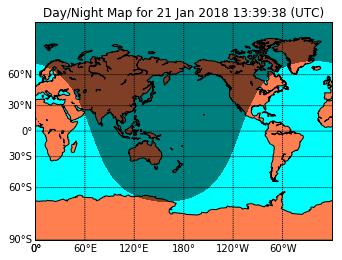

In [1]:
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from datetime import datetime
# miller projection 
map = Basemap(projection='mill',lon_0=180)
# plot coastlines, draw label meridians and parallels.
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
# fill continents 'coral' (with zorder=0), color wet areas 'aqua'
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
# shade the night areas, with alpha transparency so the 
# map shows through. Use current time in UTC.
date = datetime.utcnow()
CS=map.nightshade(date)
plt.title('Day/Night Map for %s (UTC)' % date.strftime("%d %b %Y %H:%M:%S"))
plt.show()


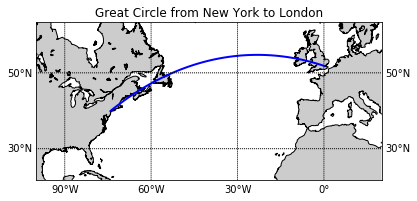

In [2]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# create new figure, axes instances.
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-100.,llcrnrlat=20.,urcrnrlon=20.,urcrnrlat=60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
# nylat, nylon are lat/lon of New York
nylat = 40.78; nylon = -73.98
# lonlat, lonlon are lat/lon of London.
lonlat = 51.53; lonlon = 0.08
# draw great circle route between NY and London
m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color='b')
m.drawcoastlines()
m.fillcontinents()
# draw parallels
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
ax.set_title('Great Circle from New York to London')
plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.basemap import Basemap, shiftgrid
from netCDF4 import Dataset
# specify date to plot.
yyyy=1993; mm=3; dd=14; hh=0
date = datetime.datetime(yyyy,mm,dd,hh)
# set OpenDAP server URL.
URLbase="http://nomads.ncdc.noaa.gov/thredds/dodsC/modeldata/cmd_pgbh/"
URL=URLbase+"%04i/%04i%02i/%04i%02i%02i/pgbh00.gdas.%04i%02i%02i%02i.grb2" %\
             (yyyy,yyyy,mm,yyyy,mm,dd,yyyy,mm,dd,hh)
data = Dataset(URL)
# read lats,lons
# reverse latitudes so they go from south to north.
latitudes = data.variables['lat'][::-1]
longitudes = data.variables['lon'][:].tolist()
# get sea level pressure and 10-m wind data.
# mult slp by 0.01 to put in units of hPa.
slpin = 0.01*data.variables['Pressure_msl'][:].squeeze()
uin = data.variables['U-component_of_wind_height_above_ground'][:].squeeze()
vin = data.variables['V-component_of_wind_height_above_ground'][:].squeeze()
# add cyclic points manually (could use addcyclic function)
slp = np.zeros((slpin.shape[0],slpin.shape[1]+1),np.float)
slp[:,0:-1] = slpin[::-1]; slp[:,-1] = slpin[::-1,0]
u = np.zeros((uin.shape[0],uin.shape[1]+1),np.float64)
u[:,0:-1] = uin[::-1]; u[:,-1] = uin[::-1,0]
v = np.zeros((vin.shape[0],vin.shape[1]+1),np.float64)
v[:,0:-1] = vin[::-1]; v[:,-1] = vin[::-1,0]
longitudes.append(360.); longitudes = np.array(longitudes)
# make 2-d grid of lons, lats
lons, lats = np.meshgrid(longitudes,latitudes)
# make orthographic basemap.
m = Basemap(resolution='c',projection='ortho',lat_0=60.,lon_0=-60.)
# create figure, add axes
fig1 = plt.figure(figsize=(8,10))
ax = fig1.add_axes([0.1,0.1,0.8,0.8])
# set desired contour levels.
clevs = np.arange(960,1061,5)
# compute native x,y coordinates of grid.
x, y = m(lons, lats)
# define parallels and meridians to draw.
parallels = np.arange(-80.,90,20.)
meridians = np.arange(0.,360.,20.)
# plot SLP contours.
CS1 = m.contour(x,y,slp,clevs,linewidths=0.5,colors='k',animated=True)
CS2 = m.contourf(x,y,slp,clevs,cmap=plt.cm.RdBu_r,animated=True)
# plot wind vectors on projection grid.
# first, shift grid so it goes from -180 to 180 (instead of 0 to 360
# in longitude).  Otherwise, interpolation is messed up.
ugrid,newlons = shiftgrid(180.,u,longitudes,start=False)
vgrid,newlons = shiftgrid(180.,v,longitudes,start=False)
# transform vectors to projection grid.
uproj,vproj,xx,yy = \
m.transform_vector(ugrid,vgrid,newlons,latitudes,31,31,returnxy=True,masked=True)
# now plot.
Q = m.quiver(xx,yy,uproj,vproj,scale=700)
# make quiver key.
qk = plt.quiverkey(Q, 0.1, 0.1, 20, '20 m/s', labelpos='W')
# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5)
m.drawparallels(parallels)
m.drawmeridians(meridians)
# add colorbar
cb = m.colorbar(CS2,"bottom", size="5%", pad="2%")
cb.set_label('hPa')
# set plot title
ax.set_title('SLP and Wind Vectors '+str(date))
plt.show()

# create 2nd figure, add axes
fig2 = plt.figure(figsize=(8,10))
ax = fig2.add_axes([0.1,0.1,0.8,0.8])
# plot SLP contours
CS1 = m.contour(x,y,slp,clevs,linewidths=0.5,colors='k',animated=True)
CS2 = m.contourf(x,y,slp,clevs,cmap=plt.cm.RdBu_r,animated=True)
# plot wind barbs over map.
barbs = m.barbs(xx,yy,uproj,vproj,length=5,barbcolor='k',flagcolor='r',linewidth=0.5)
# draw coastlines, parallels, meridians.
m.drawcoastlines(linewidth=1.5)
m.drawparallels(parallels)
m.drawmeridians(meridians)
# add colorbar
cb = m.colorbar(CS2,"bottom", size="5%", pad="2%")
cb.set_label('hPa')
# set plot title.
ax.set_title('SLP and Wind Barbs '+str(date))
plt.show()


ImportError: No module named 'netCDF4'